In [143]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from scipy.optimize import fsolve
from scipy import interp
from numpy import log, exp

beta = 0.9
rho = 1
grid_max = 1
grid_min = 1-beta
grid_size = 150
grid = np.linspace(grid_min, grid_max, grid_size)
"""
epsilon=2
B(sigma)=1
                      1             if s=0
A(s, sigma)={
                      1+sigma if s=1
C(a)=2*a**2
Sigma=[0, 1]

"""
#using static condition we express wage bill as function of a and p
#define cost function
def C(a):
    return 2*a**2


#left hand side of static condition
def lhs(sigma):
    temp1=1.5-(sigma+sigma**2/2)
    temp2=sigma*(1+sigma)**2
    return temp1/temp2
#rhs of static condition
def rhs(a, p):
    temp1=1-p
    temp2=(1-C(a))*p
    return temp1/temp2
#express critical stage as function of a and p
def cstage(a, p):
    rrhs=rhs(a, p)
    def lhsminusrhs(sigma):
        return (lhs(sigma)-rrhs)**2
    return np.asarray([fminbound(lhsminusrhs, 1e-6, 1)])


#note that wage ratio omega=1+cstage, we can now recover income
#in fact, it's income/w_0
def income(a, p):
    return (1-C(a))*p+(1-p)*(1+cstage(a, p))
#substitute income into (4) to recover w_0 and w_1
def w_0(a, p):
    temp1=income(a, p)*(cstage(a, p))
    temp2=(1-C(a))*p
    return temp1/temp2
def w_1(a, p):
    return w_0(a, p)*(1+cstage(a, p))

#now, let's define the bellman operator
def bellman_operator(W0, W1):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function TW on the grid points.

        * W is a flat NumPy array with len(W) = len(grid)

    The vector W represents the value of the input function on the grid
    points.
    """
    #==apply linear interpolation to W==#
    AW0 = lambda x: interp(x, grid, W0)
    AW1 = lambda x: interp(x, grid, W1)
    
    #==set TW0[i] equal to max_a......==#
    TW0=np.empty(grid_size)
    TW1=np.empty(grid_size)
    for i, p in enumerate(grid):
        pprime = lambda a: beta*(p-a*(1-p)*p)+1-beta
        objective = lambda a: -(1-C(a))*w_0(a, p) - beta*rho*((1-a+a*p)*AW0(pprime(a))+a*(1-p)*AW1(pprime(a)))
        a_star = fminbound(objective, 1e-6, 1)
        TW0[i] = -objective(a_star)
        TW1[i] = w_1(a_star, p)+beta*rho*AW1(pprime(a_star))
    return TW0, TW1

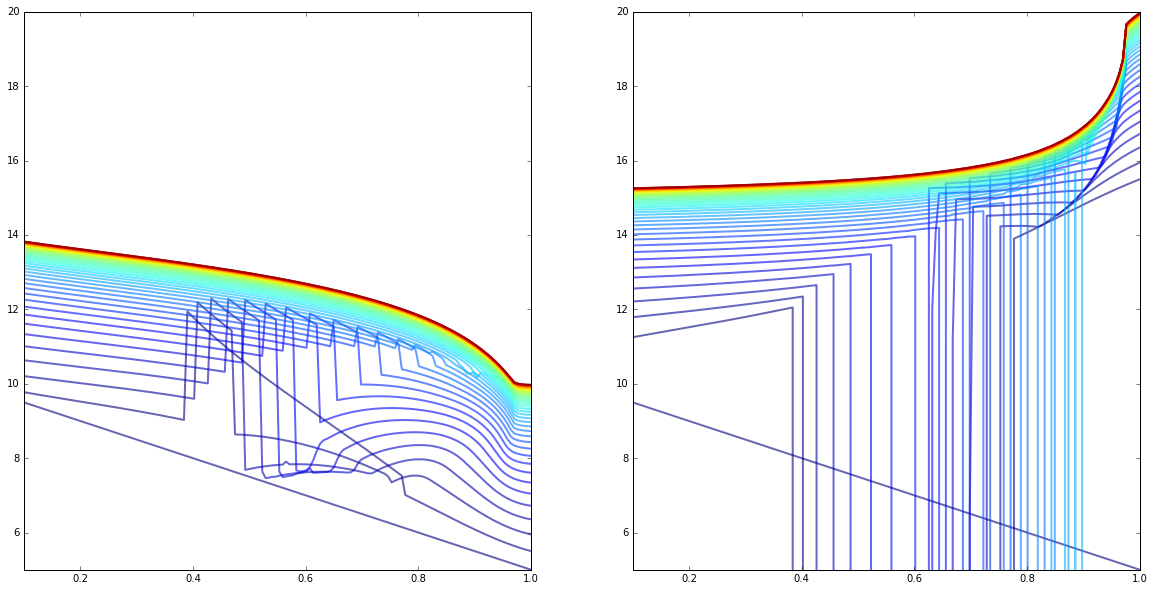

In [145]:
W0=10-5*grid
W1=10+5*grid
n=50
fig, axes=plt.subplots(1, 2, figsize=(20, 10))
ax0=axes[0]
ax1=axes[1]
ax0.set_xlim(np.min(grid), np.max(grid))
ax0.set_ylim(5, 20)
ax1.set_xlim(np.min(grid), np.max(grid))
ax1.set_ylim(5, 20)
lb='initial condition'
ax0.plot(grid, W0, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
ax1.plot(grid, W0, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    W0, W1=bellman_operator(W0, W1)
    ax0.plot(grid, W0, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
    ax1.plot(grid, W1, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
    
plt.show()

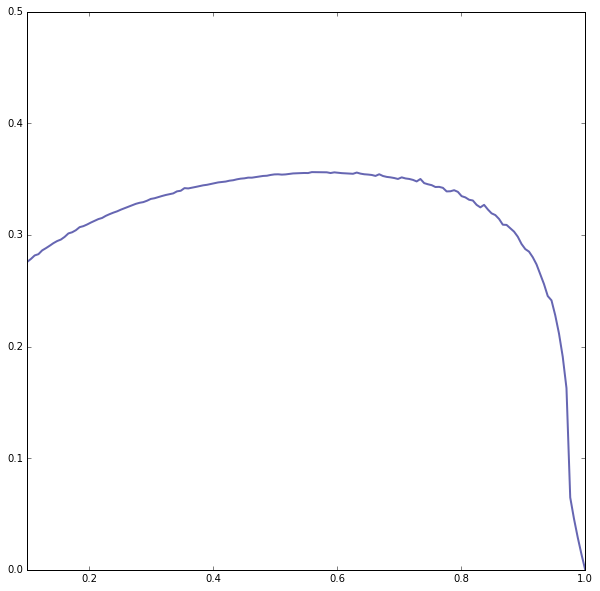

In [147]:
def compute_greedy(W0, W1):
    
    AW0=lambda x: interp(x, grid, W0)
    AW1=lambda x: interp(x, grid, W1)
    
    sigma = np.empty(grid_size)
    for i, p in enumerate(grid):
        pprime = lambda a: beta*(p-a*(1-p)*p)+1-beta
        objective = lambda a: -(1-C(a))*w_0(a, p) - beta*rho*((1-a+a*p)*AW0(pprime(a))+a*(1-p)*AW1(pprime(a)))
        sigma[i] = fminbound(objective, 1e-6, 1)
    return sigma
sigma=compute_greedy(W0, W1)
fig, ax=plt.subplots(figsize=(10, 10))
ax.set_xlim(np.min(grid), np.max(grid))
ax.set_ylim(0, 0.5)
ax.plot(grid, sigma, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
plt.show()

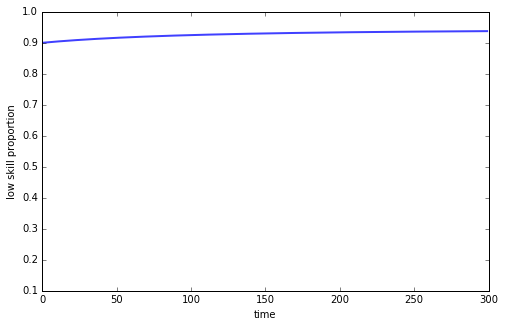

In [142]:
p0=0.5
series_length=300

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("low skill proportion")
ax.set_ylim(0.10, 1.00)

xx=np.empty(series_length)
xx[0]=0.9
sigma_function = lambda x: interp(x, grid, sigma)
for t in range(1, series_length):
    xx[t] = beta*(xx[t-1]-sigma_function(xx[t-1])*(1-xx[t-1])*xx[t-1])+1-beta
ax.plot(xx, lw=2, alpha=0.75)

plt.show()